# Importações

In [28]:
#!pip install scikit-learn pandas numpy matplotlib xgboost

In [29]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt

# Pré-processamento e pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Modelos de ML
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Validação e busca de hiperparâmetros
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

# Métricas
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Carregando dataset

In [30]:
# Carregar o dataset
df = pd.read_csv('filmes_gabriel.csv')

# Identificando e tratando outliers em variáveis numéricas do df

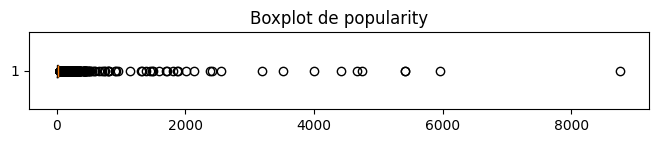

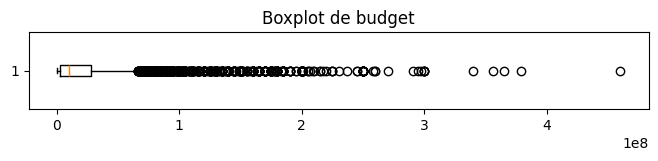

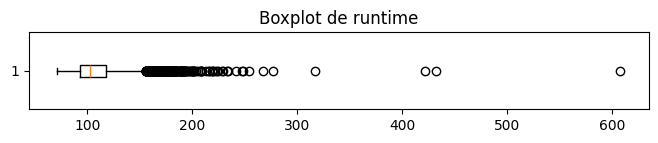

In [31]:
numeric_cols = df[['popularity', 'budget', 'runtime']].columns

for col in numeric_cols:
    plt.figure(figsize=(8, 1))
    plt.boxplot(df[col], vert=False)
    plt.title(f'Boxplot de {col}')
    plt.show()

### Tratamento com Cap nos outliers
 - Função para aplicar o "cap" nos outliers usando o método do IQR (Interquartile Range).
 - O cap limita os valores extremos (outliers) ao valor máximo permitido pelo intervalo interquartil,
 - reduzindo o impacto desses valores sem removê-los do dataset.

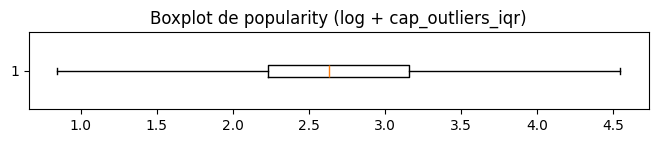

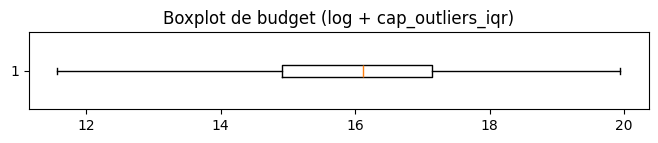

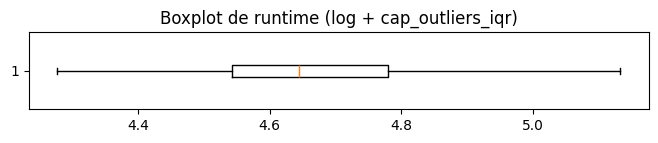

In [32]:
def log_transform(df, columns):
    for col in columns:
        # Adiciona 1 para evitar log(0)
        df[col] = np.log1p(df[col])
    return df

def cap_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower, upper)
    return df

df = log_transform(df, numeric_cols)
df = cap_outliers_iqr(df, numeric_cols)

for col in numeric_cols:
    plt.figure(figsize=(8, 1))
    plt.boxplot(df[col], vert=False)
    plt.title(f'Boxplot de {col} (log + cap_outliers_iqr)')
    plt.show()


# Treinamento
- Modelo XGBRegressor
- Modelo SVM

### Definindo as colunas de features e o target

In [33]:
X = df.drop(columns=['vote_average'])
y = df['vote_average']

# Dividindo o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=87)

categorical_col = ['original_language']
numerical_cols = [col for col in X_train.columns if col not in categorical_col]

# Definindo o KFold para o cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=87)

In [34]:

# Pré-processamento: aplica OneHot só em original_language
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_col)
    ],
    remainder='passthrough'  # mantém as colunas numéricas como estão
)

# Pipeline com pré-processador + modelo
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

# Espaço de busca aleatória para os hiperparâmetros
param_dist = {
    'regressor__n_estimators': randint(100, 300),
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': uniform(0.01, 0.3),
    'regressor__subsample': uniform(0.7, 0.3),
    'regressor__colsample_bytree': uniform(0.7, 0.3),
}

# Validação cruzada com KFold
kf = KFold(n_splits=5, shuffle=True, random_state=87)

# RandomizedSearchCV com 30 tentativas aleatórias
XGBRegressor_rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter= 60,
    cv=kf,
    scoring='r2',
    random_state=87,
    verbose=2,
    n_jobs=-1
)

# Treinamento
XGBRegressor_rand.fit(X_train, y_train)

# Resultados
print("Melhores parâmetros:", XGBRegressor_rand.best_params_)
print("Melhor R² (validação cruzada):", XGBRegressor_rand.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Melhores parâmetros: {'regressor__colsample_bytree': np.float64(0.8696231377727208), 'regressor__learning_rate': np.float64(0.05992056035524427), 'regressor__max_depth': 5, 'regressor__n_estimators': 241, 'regressor__subsample': np.float64(0.8173221947525602)}
Melhor R² (validação cruzada): 0.502139567355049


In [37]:
# Pré-processamento: OneHot para a categórica + StandardScaler para numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_col),
        ('num', StandardScaler(), numerical_cols)
    ]
)

# Pipeline com SVR
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', SVR())
])

# Espaço de busca aleatória para o SVR
param_dist = {
    'regressor__kernel': ['rbf', 'linear'],
    'regressor__C': loguniform(1e-2, 1e2),         # valores de C entre 0.01 e 100
    'regressor__epsilon': uniform(0.01, 0.3),      # valores de epsilon entre 0.01 e 0.31
    'regressor__gamma': ['scale', 'auto']
}


# RandomizedSearchCV
svm_rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,  # número de combinações aleatórias a testar
    cv=kf,
    scoring='r2',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# Treinamento
svm_rand.fit(X_train, y_train)

# Resultados
print("Melhores parâmetros:", svm_rand.best_params_)
print("Melhor R² (validação cruzada):", svm_rand.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores parâmetros: {'regressor__C': np.float64(1.1400863701127328), 'regressor__epsilon': np.float64(0.18772437065861275), 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}
Melhor R² (validação cruzada): 0.47930508051695453


# Avaliação dos modelos

In [38]:
modelos = {
    'XGBRegressor': XGBRegressor_rand,
    'SVM (StandardScaler)': svm_rand,
}

resultados = []

for nome, modelo in modelos.items():
    y_pred = modelo.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    resultados.append({'Modelo': nome, 'MSE': mse, 'RMSE': rmse, 'R²': r2})
       

resultados_df = pd.DataFrame(resultados)
print(resultados_df)

                 Modelo       MSE      RMSE        R²
0          XGBRegressor  0.403087  0.634891  0.497921
1  SVM (StandardScaler)  0.432938  0.657980  0.460738
